# Download MNIST Datset
Dataset이 없는 최초 1회만 실행

In [ ]:
# Download MNIST
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -f -d train-images-idx3-ubyte.gz
!gzip -f -d train-labels-idx1-ubyte.gz
!gzip -f -d t10k-images-idx3-ubyte.gz
!gzip -f -d t10k-labels-idx1-ubyte.gz

# Dataset & Dataloader

In [1]:
import numpy as np
import torch
from PIL import Image
from torchvision.datasets.mnist import read_image_file, read_label_file
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torchvision import transforms, utils, models
import torch.nn as nn
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Custom Dataloader to separate 0 and 1~9 label data.
class custom_MNIST(torch.utils.data.Dataset):
    training_file = "training.pt"
    test_file = "test.pt"

    def __init__(self, root = './', train = True, transform=None):
        super().__init__()
        self.root = root  
        self.train = train  # training set(True) or test set(False)
        self.data, self.targets = self._load_data()
        self.transform = transform

        if self.train: 
            self._del_zeros()

    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.root, image_file))
        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        targets = read_label_file(os.path.join(self.root, label_file))
        return data, targets
    
    def _del_zeros(self):
        idx = self.targets != 0
        self.data = self.data[idx]
        self.targets = self.targets[idx]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = img.numpy()
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def _select_index(self, index):
        self.data = self.data[index]
        self.targets = self.targets[index]

    def __len__(self):
        return len(self.data)

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

# leave 5000 images for validation
train_dataset = custom_MNIST(train=True, transform=transform)
n = len(train_dataset)
train_dataset._select_index(torch.arange(n-5000))

valid_dataset = custom_MNIST(train=True, transform=transform)
valid_dataset._select_index(torch.arange(n-5000,n))

test_dataset = custom_MNIST(train=False, transform=transform)

bs = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

/usr/local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(train_dataset), len(valid_dataset)

(49077, 5000)

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.2):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        out = tensor + (torch.randn(tensor.size()) * self.std + self.mean).to(device)
        out = torch.clamp(out,min=0,max=1)
        return out
    
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'
transform_noise = transforms.Compose([transforms.ToTensor(),
                                AddGaussianNoise(0., 0.3)])

In [5]:
class RandomMasking(object):
    def __init__(self,size=13, color=0.2):
        self.size = size
        self.color = color
        self.applyratio = 0.9
    
    def __call__(self, tensor, applyratio):
        self.applyratio = applyratio
        
        img = tensor.clone()
        margin = 2
        
        applynum = round(tensor.size(0)*self.applyratio)
        applyidx = np.random.choice(np.arange(tensor.size(0)),applynum,replace=False)
        
        x=torch.randint(low=margin, high=img.size(2)-margin-self.size,size=(applynum,))
        y=torch.randint(low=margin, high=img.size(3)-margin-self.size,size=(applynum,))
        
        s = np.random.choice(np.arange(self.size-3,self.size+2+1))

        for i in range(s):
            for j in range(s):
                img[applyidx,0,x+i,y+j]= self.color

        img = torch.clamp(img,min=0)
        return img
    
    def __repr__(self):
        return self.__class__.__name__ + f'(color={self.color}, scale={self.scale})'

### Dataset Visualization

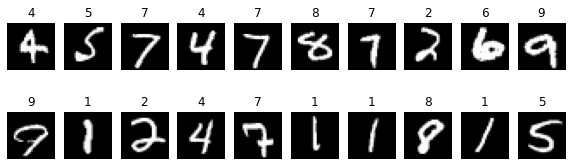

In [6]:
# Visualize Train Sample
for img,labels in train_loader:
    fig, (axs) = plt.subplots(2, 10, figsize=(10,3))
    for i in range(10):
        for j in range(2):
            axs[j,i].imshow(img[i+j*10,0],cmap='gray')
            axs[j,i].set_title(labels[i+j*10].item())
            axs[j,i].axis('off')
    break

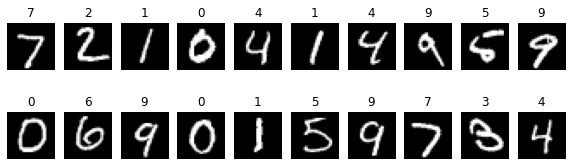

In [7]:
# Visualize Test Sample
for img,labels in test_loader:
    fig, (axs) = plt.subplots(2, 10, figsize=(10,3))
    for i in range(10):
        for j in range(2):
            axs[j,i].imshow(img[i+j*10,0],cmap='gray')
            axs[j,i].set_title(labels[i+j*10].item())
            axs[j,i].axis('off')
    break

### Util Function Definitions

In [8]:
def confusion_matrix(y, pred):
    TP_idx = (y!=0)*(pred!=0)
    FN_idx = (y!=0)*(pred==0)
    FP_idx = (y==0)*(pred!=0)
    TN_idx = (y==0)*(pred==0)

    return TP_idx, FN_idx, FP_idx, TN_idx

def eval_measures(y, pred):
    TP_idx, FN_idx, FP_idx, TN_idx = confusion_matrix(y, pred)
    TP = TP_idx.sum().item()
    FN = FN_idx.sum().item()
    FP = FP_idx.sum().item()
    TN = TN_idx.sum().item()
    
    measures_dict = dict()
    measures_dict['FPR'] = 100*FP/(TN+FP) 
    measures_dict['TPR'] = 100*TP/(TP+FN) # Recall
    
    if (TP+FP)!=0 : 
        measures_dict['precision'] = 100*TP/(TP+FP)
    else:
        measures_dict['precision'] = 0
    
    
    denom = y.size(0)
    nom = (y==pred).sum().item()
    measures_dict['acc'] = 100*nom/denom
    
    denom = (y!=0).sum().item()
    nom = (y[y!=0]==pred[y!=0]).sum().item()
    measures_dict['non-zero acc'] = 100*nom/denom
    
    denom = (y==0).sum().item()
    nom = (y[y==0]==pred[y==0]).sum().item()
    measures_dict['zero acc'] = 100*nom/denom
    
    
    return {k:round(v,2) for k,v in measures_dict.items()}

In [9]:
def thresholded_pred(pred, prob, mse, prob_t=1., mse_t=0.):
    pred_ = pred.clone()
    
    if mse == None:
        pred_[(prob<prob_t)]=0    
    elif prob == None:
        pred_[(mse>mse_t)]=0    
    else:
        pred_[(mse>mse_t)*(prob<prob_t)]=0
    
    return pred_
    

def plot_fpr(y,pred,prob=None,mse=None):
    FPR_list =[]
    TPR_list =[]
    
    zero_acc_list = []
    else_acc_list = []
    
    best_FPR = 100
    best_TPR = 0
    best_diff = best_TPR-best_FPR
    
    best_zero_acc = 0
    best_else_acc = 0
    best_total_acc = 0
    
    for threshold in np.arange(1,1001)/1000:
        
        if mse==None:
            pred2 = thresholded_pred(pred, prob, mse, prob_t = threshold)
        else:
            pred2 = thresholded_pred(pred, prob, mse, mse_t = threshold)
        
        temp = eval_measures(y,pred2)
        FPR_list.append(temp['FPR'])
        TPR_list.append(temp['TPR'])
        zero_acc_list.append(temp['zero acc'])
        else_acc_list.append(temp['non-zero acc'])
        
        if (temp['TPR']-temp['FPR'])>best_diff:
            best_diff = temp['TPR']-temp['FPR']
            best_TPR = temp['TPR']
            best_FPR = temp['FPR']
            best_threshold = threshold
            
        if (temp['zero acc']+temp['non-zero acc'])>best_total_acc:
            best_total_acc = temp['zero acc']+temp['non-zero acc']
            best_zero_acc = temp['zero acc']
            best_else_acc = temp['non-zero acc']
            best_threshold2 = threshold
        
    plt.plot(FPR_list,TPR_list)
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.annotate(f't={best_threshold} \n(FPR={best_FPR},TPR={best_TPR}) \n \
t={best_threshold2} \n(zero acc {best_zero_acc} + else acc {best_else_acc} = {best_total_acc/2:.3f}) ', \
                 xy =(best_FPR, best_TPR),xytext =(best_FPR+5, best_TPR-5),verticalalignment='top',\
                 arrowprops=dict(facecolor='black',width=0.1,headwidth=0.1))
    plt.show()
    
    return best_threshold2

In [10]:
def show_distributions(y, pred, prob):
    
    print(eval_measures(y, pred))
    TP_idx, FN_idx, FP_idx, TN_idx = confusion_matrix(y, pred)
    TP_prob, FN_prob, FP_prob, TN_prob = [prob[x].cpu().detach().numpy() if x.sum().item()>0 \
                                          else np.array(0) for x in confusion_matrix(y, pred)]

    nonzero_correct = prob[(pred==y)*(y!=0)].cpu().detach().numpy()
    nonzero_incorrect = prob[(pred!=y)*(y!=0)].cpu().detach().numpy()

    fig, (ax,ax2) = plt.subplots(1,2,figsize=(15,5),  gridspec_kw={'width_ratios': [2, 1]})

    violin = ax.violinplot([TP_prob,FN_prob, FP_prob,TN_prob], showmeans=True)
    ax.set_ylim([-0.1,1.1])
    ax.set_xticks(np.arange(1, 5))
    ax.set_xticklabels([f'TP\n({TP_idx.sum().item()})', f'FN\n({FN_idx.sum().item()})',\
                        f'FP\n({FP_idx.sum().item()})', f'TN\n({TN_idx.sum().item()})'])
    ax.set_ylabel('Softmax value distributions')
    ax.grid(linestyle='--')
    
    i=1
    for p in [TP_prob, FN_prob, FP_prob, TN_prob]:
        mean = round(p.mean(),4)
        ax.annotate(mean, xy =(i, mean),xytext =(i+0.1, mean),verticalalignment='center')
        i+=1

    violin['bodies'][0].set_facecolor('blue')
    violin['bodies'][1].set_facecolor('yellow')
    violin['bodies'][2].set_facecolor('red')
    violin['bodies'][3].set_facecolor('green')

    for t in ['cbars','cmaxes','cmins','cmeans']:
        violin[t].set_edgecolor('gray')
        
    
    violin2 = ax2.violinplot([nonzero_correct, nonzero_incorrect], showmeans=True)
    ax2.set_ylim([-0.1,1.1])
    ax2.set_xticks(np.arange(1, 3))
    ax2.set_xticklabels([f'1~9 correct\n({nonzero_correct.size})',\
                        f'1~9 incorrect\n({nonzero_incorrect.size})'])
    ax2.set_ylabel('Softmax value distributions')
    ax2.grid(linestyle='--')
    
    violin2['bodies'][0].set_facecolor('blue')
    violin2['bodies'][1].set_facecolor('blue')

    for t in ['cbars','cmaxes','cmins','cmeans']:
        violin2[t].set_edgecolor('gray')
        
    i=1
    for p in [nonzero_correct, nonzero_incorrect]:
        mean = round(p.mean(),4)
        ax2.annotate(mean, xy =(i, mean),xytext =(i+0.1, mean),verticalalignment='center')
        i+=1

    plt.show()

In [11]:
def show_distributions2(tensor, label, ytext=''):
    dict_ = dict()
    
    for l in (torch.unique(label)):
        idx = (label==l)
        dict_[l.item()] = tensor[idx].detach().cpu()

    fig, ax = plt.subplots(figsize=(25,5))

    violin = ax.violinplot(dict_.values(), showmeans=True, showmedians=True)
    ax.set_xticks(np.arange(1,11))
    ax.set_xticklabels(np.arange(10))
    ax.set_ylabel(ytext)
    ax.grid(linestyle='--')

    i=1
    #{k:v.mean().item() for k,v in mse_by_label.items()}
    for k,v in dict_.items():
        mean = round(torch.Tensor.float(v).mean().item(),4)
        ax.annotate(mean, xy =(i, mean),xytext =(i+0.2, mean),verticalalignment='center',color='steelblue')
        i+=1

    violin['bodies'][0].set_facecolor('salmon')

    for t in ['cbars','cmaxes','cmins','cmedians']:
        violin[t].set_edgecolor('gray')
    violin['cmeans'].set_edgecolor('steelblue')


    plt.show()

# Design your method
Design your own model and training process

In [12]:
class StdLoss(nn.Module):
    def __init__(self):
        super(StdLoss,self).__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,output,target):
        
        logit = self.softmax(output)
            
        wrong_idx = ((logit.max(dim=1)[1])!=target)
        std = logit[wrong_idx].std(dim=1)
        loss = std.mean() if std.size(0)>0 else 0
        
        return loss

In [13]:
class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss,self).__init__()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self,output,target,k=1):
        logit = self.softmax(output)
        
        idx = torch.arange(output.size(0))
        
        target_onehot = torch.zeros((output.size(0),10),dtype=torch.bool).to(device)
        target_onehot[idx,target] = True
        
        loss = -(torch.log(logit[target_onehot]+1e-4)).mean() #-torch.log(logit[idx,target]).mean()
        loss += -k*(logit[target_onehot==False]*torch.log(1-logit[target_onehot==False]+1e-4)).view(-1,9).sum(dim=1).mean()

        return loss

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        resnet18 = models.resnet18(pretrained=True)
        resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        
        self.encoder = nn.Sequential(*list(resnet18.children()))[:-3]
        
        self.decoder  = nn.Sequential(
                nn.ConvTranspose2d(128,64,kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(64,16,kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(16,8,kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.Conv2d(8,1,kernel_size=3, stride=1, padding=0),
                nn.Tanh(),
            )
        
        
        self.classifier = nn.Linear(256*2*2,10,bias=True)
        self.thresholds = None
        self.T=1
        self.mseLoss = nn.MSELoss()
        
    def forward(self, x):
        
        if (self.training) : 
            self.thresholds = None
            
            out = self.encoder[:-1](x)

            denoised = self.decoder(out)

            feature = self.encoder[-1](out)
            feature = feature.view(-1,256*2*2)
            out = self.classifier(feature)
            
            return denoised, out
        
        
        else:
            
            if self.thresholds == None:
                
                embed_clf = self.encoder(x)
                out = self.classifier(embed_clf.flatten(1))
                
                return out
            
            else:
                
                embed_clf = self.encoder(x)
                out = self.classifier(embed_clf.flatten(1))/self.T
                logit = nn.Softmax(dim=1)(out)
                prob, _ = logit.max(dim=1)
                
                noised = addnoise(x) 
                noised = randomMasking(noised,1)
                embed_den = self.encoder[:-1](noised)
                denoised = self.decoder(embed_den)
                
                logit_ = logit.clone()
                
                mse_total = []
                for i in range(x.size(0)):
                    mse_total.append((self.mseLoss(x[i],denoised[i]).item()))
                mse_total = torch.tensor(mse_total).to(device)

                onehot_zero =torch.tensor([1.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).to(device)
                logit_[(prob<self.thresholds[0])*(mse_total>self.thresholds[1])] = onehot_zero
                
                return logit_
                
    
    def set_threshold(self, valid_data, valid_label):
        
        with torch.no_grad():
            embed_clf = self.encoder(valid_data)
            out = self.classifier(embed_clf.flatten(1))/self.T
            logit = nn.Softmax(dim=1)(out)
            prob, pred = logit.max(dim=1)

            noised = randomMasking(valid_data,1)
            noised = addnoise(noised)
            embed_den = self.encoder[:-1](noised)
            denoised = self.decoder(embed_den)
            
        mse_total = []
        for i in range(valid_data.size(0)):
            mse_total.append((mseLoss(valid_data[i],denoised[i]).item()))
        mse_total = torch.tensor(mse_total).to(device)

        mse_t = mse_total[valid_label==0].sort()[0][0].item()
        prob_t = self.get_prob_t(valid_label,pred,prob)

        self.thresholds = (prob_t, mse_t)
        print('thresholds set : ', self.thresholds)
        
    def get_prob_t(self, y, pred, prob):
        zero_acc_list = []
        else_acc_list = []

        best_zero_acc = 0
        best_else_acc = 0
        best_total_acc = 0

        for threshold in np.arange(1,1001)/1000:
            pred_ = pred.clone()
            pred_[prob<threshold]=0
            temp = eval_measures(y,pred_)
            zero_acc_list.append(temp['zero acc'])
            else_acc_list.append(temp['non-zero acc'])

            if (temp['zero acc']+temp['non-zero acc'])>best_total_acc:
                best_total_acc = temp['zero acc']+temp['non-zero acc']
                best_zero_acc = temp['zero acc']
                best_else_acc = temp['non-zero acc']
                best_threshold = threshold
                
        return best_threshold
        


In [15]:
model = Model()
mseLoss =  nn.MSELoss()
#ceLoss = nn.CrossEntropyLoss()
stdLoss = StdLoss()
focalLoss = FocalLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

addnoise = AddGaussianNoise(mean=0.5, std=0.25)
randomMasking = RandomMasking(color=0.9)

In [ ]:
# training

model.to(device)

iteration = 0
lambda_ = 0.0
start = time.time()
for epoch in range(3):
    for i, (data, label) in enumerate(train_loader):
        
        model.train()
        data = data.to(device)
        label = label.to(device)
        
        
        noised = randomMasking(data,0.8)
        noised = addnoise(noised)

        optimizer.zero_grad()
        
        denoised, out = model(noised)
        
        recon_loss = mseLoss(denoised,data)
        #clf_loss = ceLoss(out,label) + 1*stdloss(out,label)
        clf_loss = focalLoss(out,label) + 1*stdLoss(out,label)
        
        loss = recon_loss + lambda_*clf_loss
        
        loss.backward()
        optimizer.step()
        
        
        # Validation at every 1000 iteration
        if (iteration%500==0):
            print(f'{iteration}th iteration, elapsed time : {time.time()-start :.2f} sec')
            print(f'loss: {recon_loss:.4f} + {lambda_*clf_loss:.4f}')
            with torch.no_grad():
                
                model.eval()

                total = 0
                correct = 0

                recon_loss = 0
                clf_loss = 0

                for data, label in valid_loader:
                    data = data.to(device)
                    label = label.to(device)

                    out = model(data)

                    _, pred = torch.max(out,dim=1)

                    total += label.size(0)
                    correct += (pred == label).sum().item()

            acc = 100*correct/total
            print(f'prediction accuracy : {acc:.3f}%\n')
            start = time.time()
            
        iteration += 1
        if (iteration == 2001):
            lambda_ = 0.01
            print(f'>>>lambda set to {lambda_}')
            
print(f"Training Done(total {iteration} iteration)")

In [43]:
model = Model()
model.to(device)
model.load_state_dict(torch.load('./weights/송유진_2019142002_최종weight.pt'))

<All keys matched successfully>

In [44]:
for data, label in valid_loader:
    data = data.to(device)
    label = label.to(device)

m = 500
zero_label = torch.zeros(m,dtype=torch.int64).to(device)
data_ = data[-m:].clone()
data_ = torch.rot90(data_,k=1,dims=[2,3])

# model.train()
# randomMaskingLarge = RandomMasking(size=15, color=0.9)
# with torch.no_grad():
#     noised = randomMaskingLarge(data_,1)
#     noised = addnoise(noised)
#     data_, _ = model(noised)

valid_data = torch.cat((data[:-m],data_),dim=0)
valid_label = torch.cat((label[:-m],zero_label),dim=0)

print(valid_data.shape, valid_label.shape)

torch.Size([5000, 1, 28, 28]) torch.Size([5000])


In [45]:
model.set_threshold(valid_data,valid_label)

thresholds set :  (0.676, 0.015107386745512486)


## Plotting Results

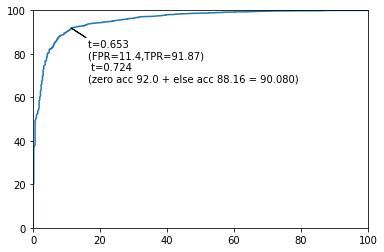

In [19]:
model.train()

addnoise = AddGaussianNoise(mean=0.5, std=0.25)
randomMasking = RandomMasking(color=0.9)

T=model.T
with torch.no_grad():
    _,out = model(valid_data)

    logit = nn.Softmax(dim=1)(out/T)
    prob, pred = logit.max(dim=1)

    noised = randomMasking(valid_data,1)
    noised = addnoise(noised)
    denoised, _ = model(noised)

mse_total = []
for i in range(valid_data.size(0)):
    mse_total.append((mseLoss(valid_data[i],denoised[i]).item()))
mse_total = torch.tensor(mse_total).to(device)

mse_t = mse_total[valid_label==0].sort()[0][0].item()
pred_t = plot_fpr(valid_label,pred,prob=prob)

In [ ]:
#show_distributions2(prob.detach(), label, ytext='Denoiser Logit')
show_distributions2(mse_total, valid_label, ytext='Reconstruction Loss(MSE)')
show_distributions(valid_label, pred, prob)
show_distributions(valid_label, thresholded_pred(pred,prob,mse_total,prob_t=0.653,mse_t=0.00), prob)

In [ ]:
k=0

In [ ]:
zero_idx = torch.arange(label.size(0))[(valid_label==5)]
show_idx = np.random.choice(zero_idx,size=10,replace=False)

plt.figure(figsize=(20,7))
for i in range(1,1+10):
    temp1 = f'pred : {pred[show_idx[i-1]]}({prob[show_idx[i-1]]:.2f})'
    
    plt.subplot(3,10,i)
    plt.title(f'label : {valid_label[show_idx[i-1]]}')
    plt.tick_params(left = False, labelleft = False,labelbottom = False, bottom = False)
    plt.imshow(valid_data[show_idx[i-1]].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
    
    plt.subplot(3,10,10+i)
    plt.tick_params(left = False, labelleft = False,labelbottom = False, bottom = False)
    plt.title(temp1)
    plt.imshow(noised[show_idx[i-1]].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
    
    plt.subplot(3,10,20+i)
    plt.title(f'\n mse : {mse_total[show_idx[i-1]].item():.4f}')
    plt.tick_params(left = False, labelleft = False,labelbottom = False, bottom = False)
    plt.imshow(denoised[show_idx[i-1]].detach().cpu().numpy().transpose(1,2,0),cmap='gray')

In [ ]:
show_idx = mse_total.squeeze().sort(descending=True)[1].detach().cpu().numpy()

plt.figure(figsize=(20,7))
for i in range(1,1+10):
    plt.subplot(3,10,i)
    plt.title(f'label : {valid_label[show_idx[i-1]]}')
    plt.tick_params(left = False, labelleft = False,labelbottom = False, bottom = False)
    plt.imshow(valid_data[show_idx[i-1]].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
    
    plt.subplot(3,10,10+i)
    plt.tick_params(left = False, labelleft = False,labelbottom = False, bottom = False)
    temp1 = f'pred : {pred[show_idx[i-1]]}({prob[show_idx[i-1]]:.2f})'
    plt.title(temp1)
    plt.imshow(noised[show_idx[i-1]].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
    
    plt.subplot(3,10,20+i)
    plt.title(f'\n mse : {mse_total[show_idx[i-1]].item():.4f}')
    plt.tick_params(left = False, labelleft = False,labelbottom = False, bottom = False)
    plt.imshow(denoised[show_idx[i-1]].detach().cpu().numpy().transpose(1,2,0),cmap='gray')

In [ ]:
n=200
temp = valid_label[mse_total.squeeze().sort(descending=True)[1]][:n]
dict_ = dict()
for l in (torch.unique(valid_label)):
    dict_[l.item()] = (temp==l).sum()
    
plt.figure(figsize=(10,5))
plt.bar(dict_.keys(),dict_.values(),color='skyblue')
plt.title(f'Top {n} Reconstruction Loss(MSE)')
plt.xticks(torch.unique(label).detach().cpu().numpy())
plt.ylabel('# of instances')
plt.xlabel('label')
plt.grid()

plt.show()

# Test Your Model
## **Do not modify this cell**
zero(0) / else(1~9) Accuracy 따로 측정



In [25]:
class Meter:
    def __init__(self):
        self.list = []
    def update(self, item):
        self.list.append(item)
    def avg(self):
        return torch.tensor(self.list).mean() if len(self.list) else None

def compute_accuracy(logits, labels):
    pred = torch.argmax(logits, dim=1)
    zero_idx= ((labels==0).nonzero(as_tuple=True)[0])
    else_idx= ((labels!=0).nonzero(as_tuple=True)[0])

    if len(zero_idx) == 0:
        zero_acc = None
        else_acc = (pred[else_idx] == labels[else_idx]).type(torch.float).mean().item()*100
    else:
        zero_acc = (pred[zero_idx] == labels[zero_idx]).type(torch.float).mean().item()*100
        else_acc = (pred[else_idx] == labels[else_idx]).type(torch.float).mean().item()*100
    return zero_acc, else_acc

In [46]:
acc_zero = Meter()
acc_else = Meter()

with torch.no_grad():
    model.eval()
    for i, (data, labels) in enumerate(test_loader):
        # Get 0~9 classification output logits / size : Batch x 10
        data = data.to(device)
        labels = labels.to(device)
        
        logits = model(data)

        zero_acc, else_acc = compute_accuracy(logits, labels)
        if zero_acc != None:
            acc_zero.update(zero_acc)
            acc_else.update(else_acc)
        else:
            acc_else.update(else_acc)

print("zero_acc: {:.4f}, else_acc: {:.4f}".format(acc_zero.avg(), acc_else.avg()))

zero_acc: 96.4372, else_acc: 89.8528
